# EcoDynElec - Enr Model - Export for EcoDynElec - 2016 to 2022

This notebook allows you to merge the 2016-2022 predicted data csv (generated in the example notebook for wind and solar energy) with the rest of the Pronovo data from May 2020 to December 2022 (including Biogas, Biomass and renewable Waste productions).
Pronovo and EnergyCharts (EC) data are compared over the whole time period to choose the best data for each renewable power production mean.
The resulting csv file can then be used in EcoDynElec to complete the ENTSO-E data.

**Note :** This notebook is not meant to be run as is, but rather to be used as a reference to understand how the data was merged and reorganized.
This process is fully implemented in EcoDynElecs' `ecodynelec.preprocessing.enr_residual_utils` module, and can be run with the `ecodynelec.preprocessing.get_enr_data_from_pronovo_ec` function.

### 0. Utility functions

In [1]:
from datetime import timedelta
# auto reload modules
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ecodynelec.preprocessing import enr_residual_utils
from ecodynelec.preprocessing.enr_residual_utils import pronovo_types_map, load_all_pronovo_files, \
    read_enr_data_from_energy_charts, reorganize_enr_data

from ecodynelec_enr_model.data_loading import root_dir

In [2]:
def plt_compare_data_sources(src_filter, pronovo_data, ec_data, title):
    """
    Plots the pronovo and energy charts data against each other
    """

    cls = [c for c in pronovo_data.columns if src_filter(c)]
    fig = plt.figure(figsize=(16, 5))
    pronovo_data.resample('D').sum()[cls].plot(ax=fig.gca())
    cls2 = [c for c in ec_data.columns if src_filter(c)]
    (ec_data.resample('D').sum()[cls2] * 1000000).plot(ax=fig.gca())

    cls = [f'{c} (Pronovo)' for c in cls]
    cls2 = [f'{c} (EC)' for c in cls2]
    plt.legend(np.concatenate([cls, cls2]))
    plt.title(title)
    plt.ylabel('Electricity production (kWh)')
    plt.show(True)

### 1. Load and reorganize the data from Pronovo

Read Pronovo data

In [3]:
years = [2020, 2021, 2022]
years = [f'prod_{year}' for year in years]
types = list(pronovo_types_map['2'].keys())
types.append('Biomass_all')
verbose = False

pronovo_data = load_all_pronovo_files(root_dir, years, types=types, verbose=verbose)
final_data = pronovo_data.sort_index()

FileNotFoundError: [WinError 3] The system cannot find the path specified: './ecd_enr_model/prod_2020'

Read EnergyCharts (EC) data

In [7]:
df_ec_data = read_enr_data_from_energy_charts('./', verbose=verbose)

#### Plot and compare them

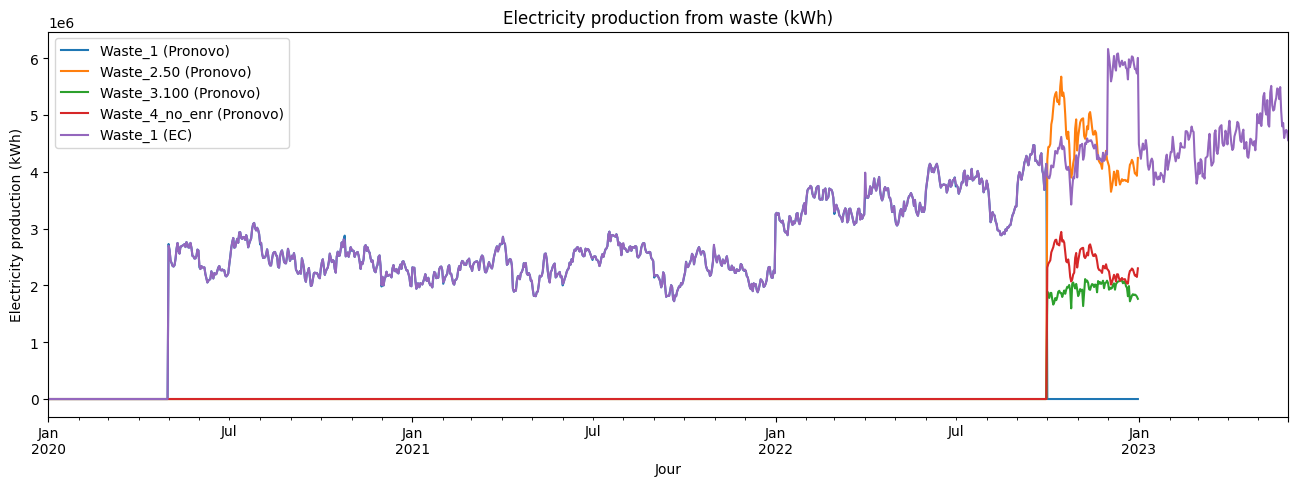

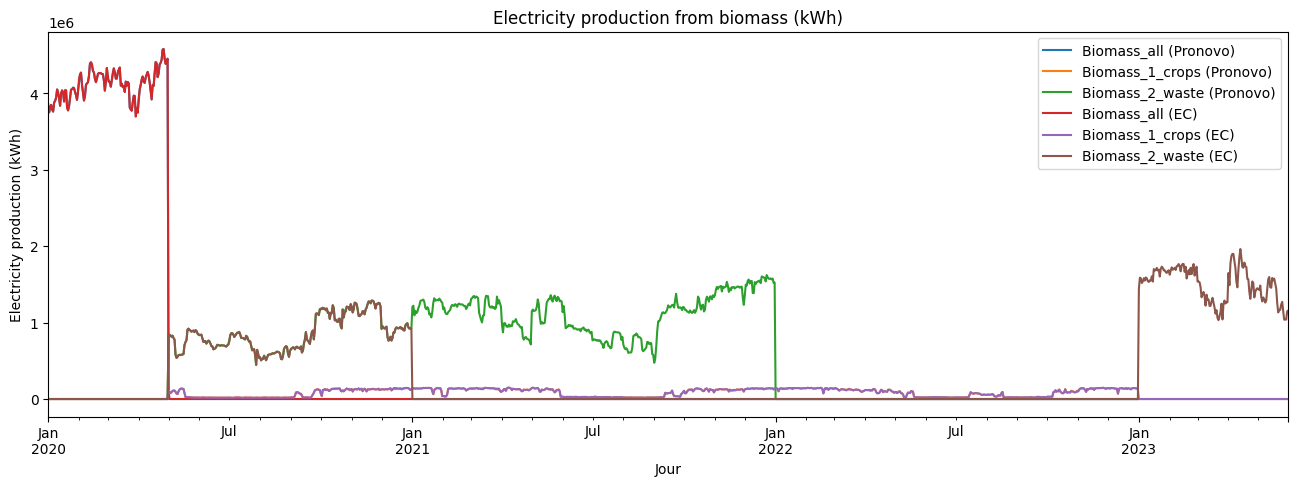

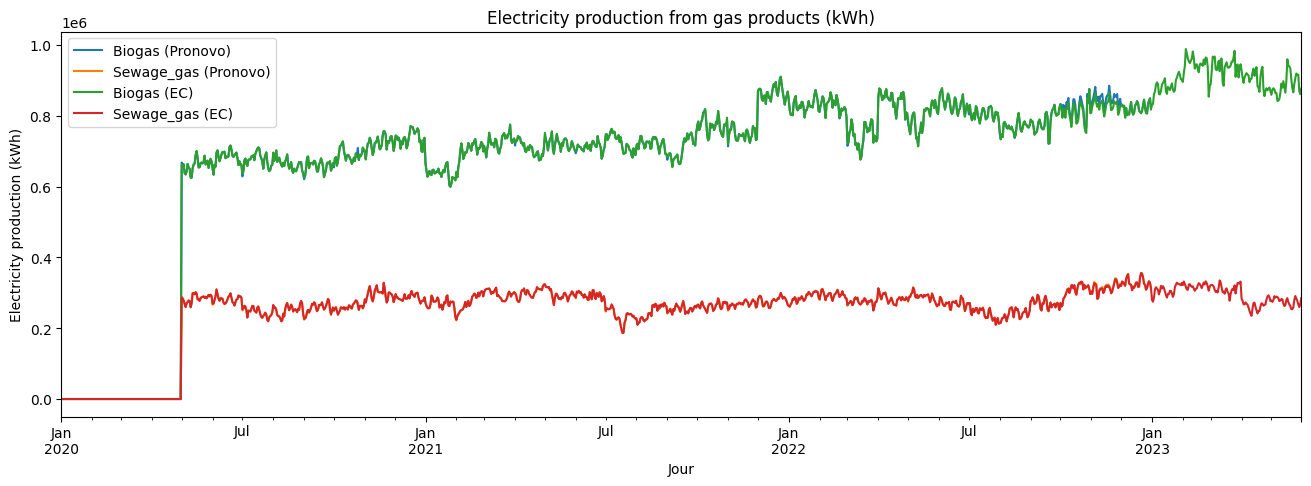

In [8]:
plt_compare_data_sources(lambda c: 'Waste' in c, final_data, df_ec_data, 'Electricity production from waste (kWh)')
plt_compare_data_sources(lambda c: 'Biomass' in c, final_data, df_ec_data, 'Electricity production from biomass (kWh)')
plt_compare_data_sources(lambda c: 'gas' in c, final_data, df_ec_data, 'Electricity production from gas products (kWh)')

#### Reorganization rules

Here we select the best data source for each electricity production mean, for each time period.

Should follow the structure :
```
'Category1': [
    {
        'start': 'start date', # start date in the result (and in source data if from_start isn't set)
        'end': 'end date', # end date in the result (and in source data if from_end isn't set)
        'from_start': '2021-01-01', # optional, start date in the source data (allows to copy data from one date to another)
        'from_end': '2021-12-31', # optional, end data in the source data
        'source': 'Pronovo' or 'EC', # source of the data
        'series': 'Series_Name_In_Source_Data' # name of the column to take in the source data
    },
    ...
],
...
```

**We override the default data mappings from the ecodynelec library to do our custom reorganiation.**

In [9]:
enr_residual_utils.data_mappings = {
    'Solar': [
        {
            'start': '2020-01-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Solar'
        }
    ],
    'Wind': [
        {
            'start': '2020-01-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Wind'
        }
    ],
    'Waste': [
        {
            'start': '2020-05-01',
            'end': '2022-09-30',
            'source': 'Pronovo',
            'series': 'Waste_1'
        },
        {
            'start': '2022-10-01',
            'end': '2022-11-30',
            'from_start': '2021-10-01',
            'from_end': '2021-11-30',
            'source': 'EC',
            'series': 'Waste_1'
        },
        {
            'start': '2022-12-01',
            'end': '2022-12-31',
            'source': 'Pronovo',
            'series': 'Waste_2.50'
        },
        {
            'start': '2023-01-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Waste_1'
        }
    ],
    'Biogas': [
        {
            'start': '2020-05-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Biogas'
        }
    ],
    'Sewage_gas': [
        {
            'start': '2020-05-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Sewage_gas'
        }
    ],
    'Biomass_1_crops': [
        {
            'start': '2020-05-01',
            'end': '2022-12-31',
            'source': 'Pronovo',
            'series': 'Biomass_1_crops'
        }
    ],
    'Biomass_2_waste': [
        {
            'start': '2020-05-01',
            'end': '2021-12-31',
            'source': 'Pronovo',
            'series': 'Biomass_2_waste'
        },
        {
            'start': '2022-01-01',
            'end': '2022-12-31',
            'from_start': '2021-01-01',
            'from_end': '2021-12-31',
            'source': 'Pronovo',
            'series': 'Biomass_2_waste'
        },
        {
            'start': '2023-01-01',
            'end': 'last',
            'source': 'Pronovo',
            'series': 'Biomass_2_waste'
        }
    ]
}

Then we apply these reorganization rules :

In [46]:
mapped_data = reorganize_enr_data(final_data, df_ec_data)

Plot the reorganized production data

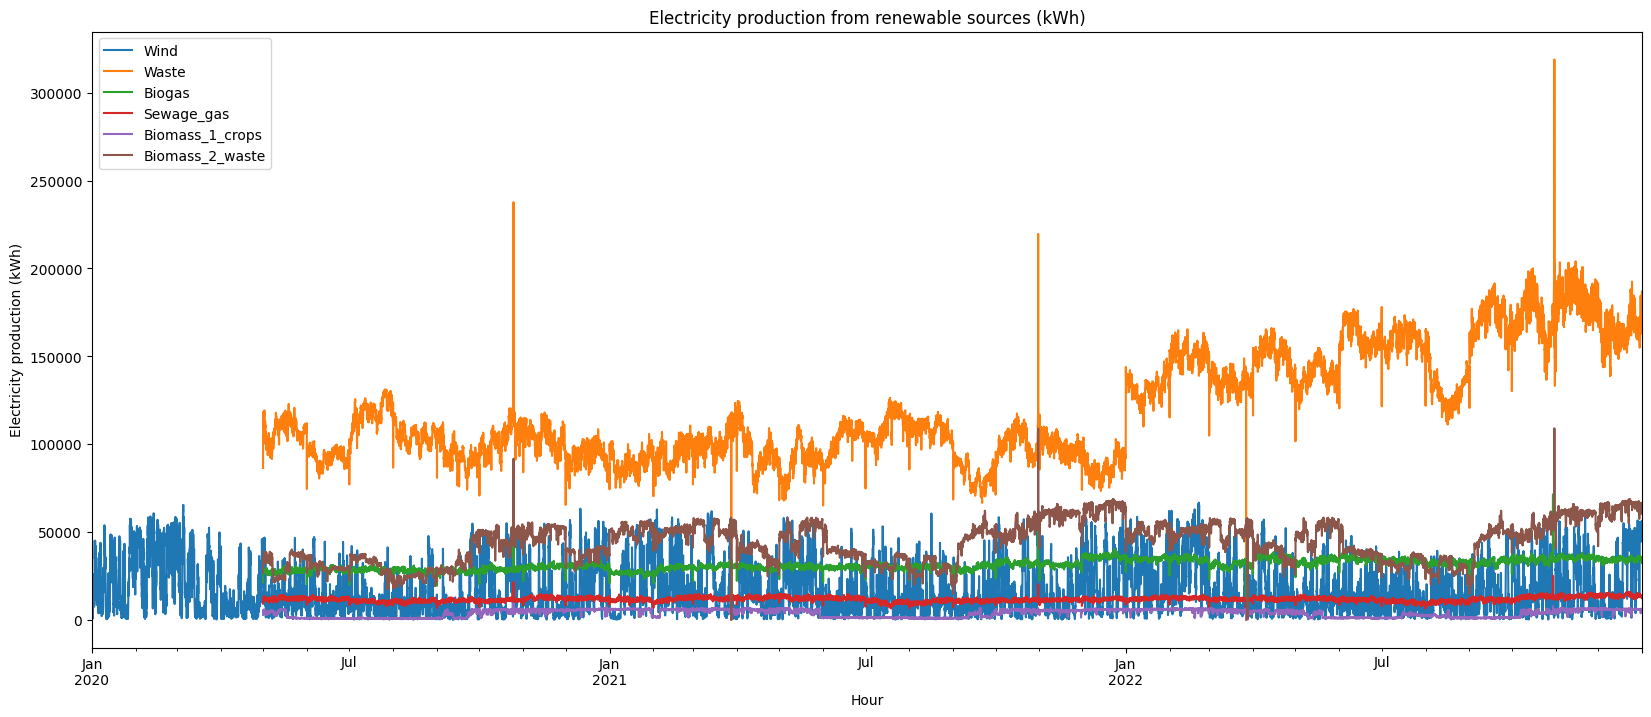

In [47]:
mapped_data.drop(columns=["Solar"]).plot(figsize=(20, 8))
plt.title('Electricity production from renewable sources (kWh)')
plt.xlabel('Hour')
plt.ylabel('Electricity production (kWh)');

And save it

In [48]:
mapped_data = mapped_data.loc['2020-01-01':'2023-03-31 00:00:00']
mapped_data.to_csv('recomposed_biomass.csv')

### 2. Load the wind and solar data from Ecd-Enr-Model (example notebook)

In [49]:
solarwind = pd.read_csv('ecd_enr_model/export/enr_prod_2016-2022.csv', index_col=0, parse_dates=[0])

### 3. Merge it

In [14]:
#mapped_data = pd.read_csv('recomposed_biomass.csv', index_col=0, parse_dates=[0])

In [42]:
ndf = pd.concat([solarwind.loc[:(mapped_data.index[0] - timedelta(hours=1))], mapped_data], axis=0)
ndf.fillna(0, inplace=True)

Plot it

<Axes: >

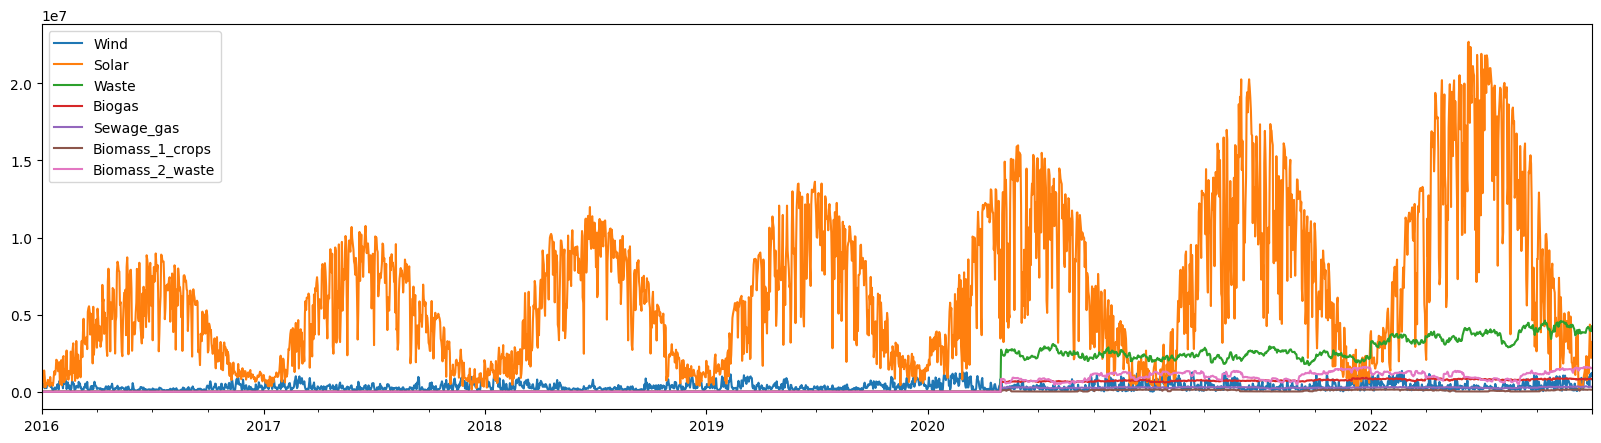

In [43]:
ndf.resample('D').sum().plot(figsize=(20, 5))

And save it

In [44]:
ndf.to_csv('ecd_enr_model/export/enr_prod_2016-2022_completed.csv')

In [45]:
ndf.loc['2020-04-30':'2020-05-02']

,Wind,Solar,Waste,Biogas,Sewage_gas,Biomass_1_crops,Biomass_2_waste
2020-04-30 00:00:00,18597.801,55.245392,0.0000,0.000,0.000,0.000,0.000
2020-04-30 01:00:00,21012.848,45.936766,0.0000,0.000,0.000,0.000,0.000
2020-04-30 02:00:00,27261.077,37.029122,0.0000,0.000,0.000,0.000,0.000
2020-04-30 03:00:00,35996.336,38.388545,0.0000,0.000,0.000,0.000,0.000
2020-04-30 04:00:00,45492.415,43.3255,0.0000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...
2020-05-02 19:00:00,9928.768,79942.842771,99930.7630,26868.672,12087.218,3596.246,38276.852
2020-05-02 20:00:00,7606.493,17726.393279,100696.4030,26455.153,11744.048,3619.449,37162.729
2020-05-02 21:00:00,9492.625,140.387806,100438.8920,27262.653,11291.321,3480.061,36200.161
2020-05-02 22:00:00,2853.613,123.730532,101842.9895,27228.148,11032.931,3054.789,33455.322
